In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from os import listdir
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.applications import imagenet_utils
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
def load_doc(filename):
    file = open(filename,'r')
    text = file.read()
    return text

In [3]:
train_features = load(open("encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [4]:
test_features = load(open("encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

Photos: test=1000


In [5]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return (dataset)

In [6]:
# load training dataset (6K)
train_text_filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(train_text_filename)
print('Train-Dataset: %d' % len(train))

Train-Dataset: 6000


In [7]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [19]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
print(len(all_train_captions))

train_cap=all_train_captions
train_cap=str('\n'.join(train_cap))
all_train_captions=open('all_train_captions.txt','w')
all_train_captions.write(train_cap)

30000


2007332

In [20]:
# load training dataset (6K)
test_text_filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(test_text_filename)
print('Test-Dataset: %d' % len(test))

Test-Dataset: 1000


In [21]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: train=%d' % len(test_descriptions))

Descriptions: train=1000


In [11]:
# Create a list of all the training captions
all_test_captions = []
for key, val in test_descriptions.items():
    for cap in val:
        all_test_captions.append(cap)
print(len(all_test_captions))

5000


In [12]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 5
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 2530


In [13]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
    
with open('w2i.pkl','wb') as pkl_file:
    dump(wordtoix,pkl_file)
with open('i2w.pkl','wb') as pkl_file:
    dump(ixtoword,pkl_file)

In [14]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

2531

In [15]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [16]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0



In [18]:
# Load Glove vectors
glove_dir = 'glove.6B'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [19]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [20]:
embedding_matrix.shape

(2531, 200)

In [21]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      506200      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [23]:
model.layers[2]

In [24]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      506200      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [33]:
epochs = 35
LR=0.0001
opt = Adam(lr=LR, decay = LR/epochs)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [34]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [35]:
filepath= 'VGG16_models/ck-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
vgenerator= data_generator(test_descriptions, test_features, wordtoix, max_length, number_pics_per_bath)
H2 = model.fit_generator(generator, epochs=epochs, steps_per_epoch=steps,callbacks=[checkpoint], verbose=1,validation_data=vgenerator,validation_steps=steps)

Epoch 1/35
2000/2000 [==============================] - 121s 61ms/step - loss: 5.0316 - acc: 0.1696 - val_loss: 4.5632 - val_acc: 0.2117

Epoch 00001: val_loss improved from inf to 4.56319, saving model to VGG16_models/ck-loss5.035-val_loss4.563.h5
Epoch 2/35
2000/2000 [==============================] - 120s 60ms/step - loss: 4.4080 - acc: 0.2212 - val_loss: 4.1988 - val_acc: 0.2378

Epoch 00002: val_loss improved from 4.56319 to 4.19877, saving model to VGG16_models/ck-loss4.412-val_loss4.199.h5
Epoch 3/35
2000/2000 [==============================] - 122s 61ms/step - loss: 4.1270 - acc: 0.2401 - val_loss: 3.9937 - val_acc: 0.2512

Epoch 00003: val_loss improved from 4.19877 to 3.99367, saving model to VGG16_models/ck-loss4.131-val_loss3.994.h5
Epoch 4/35
2000/2000 [==============================] - 124s 62ms/step - loss: 3.9409 - acc: 0.2516 - val_loss: 3.8544 - val_acc: 0.2634

Epoch 00004: val_loss improved from 3.99367 to 3.85444, saving model to VGG16_models/ck-loss3.945-val_loss3

<Figure size 432x288 with 0 Axes>

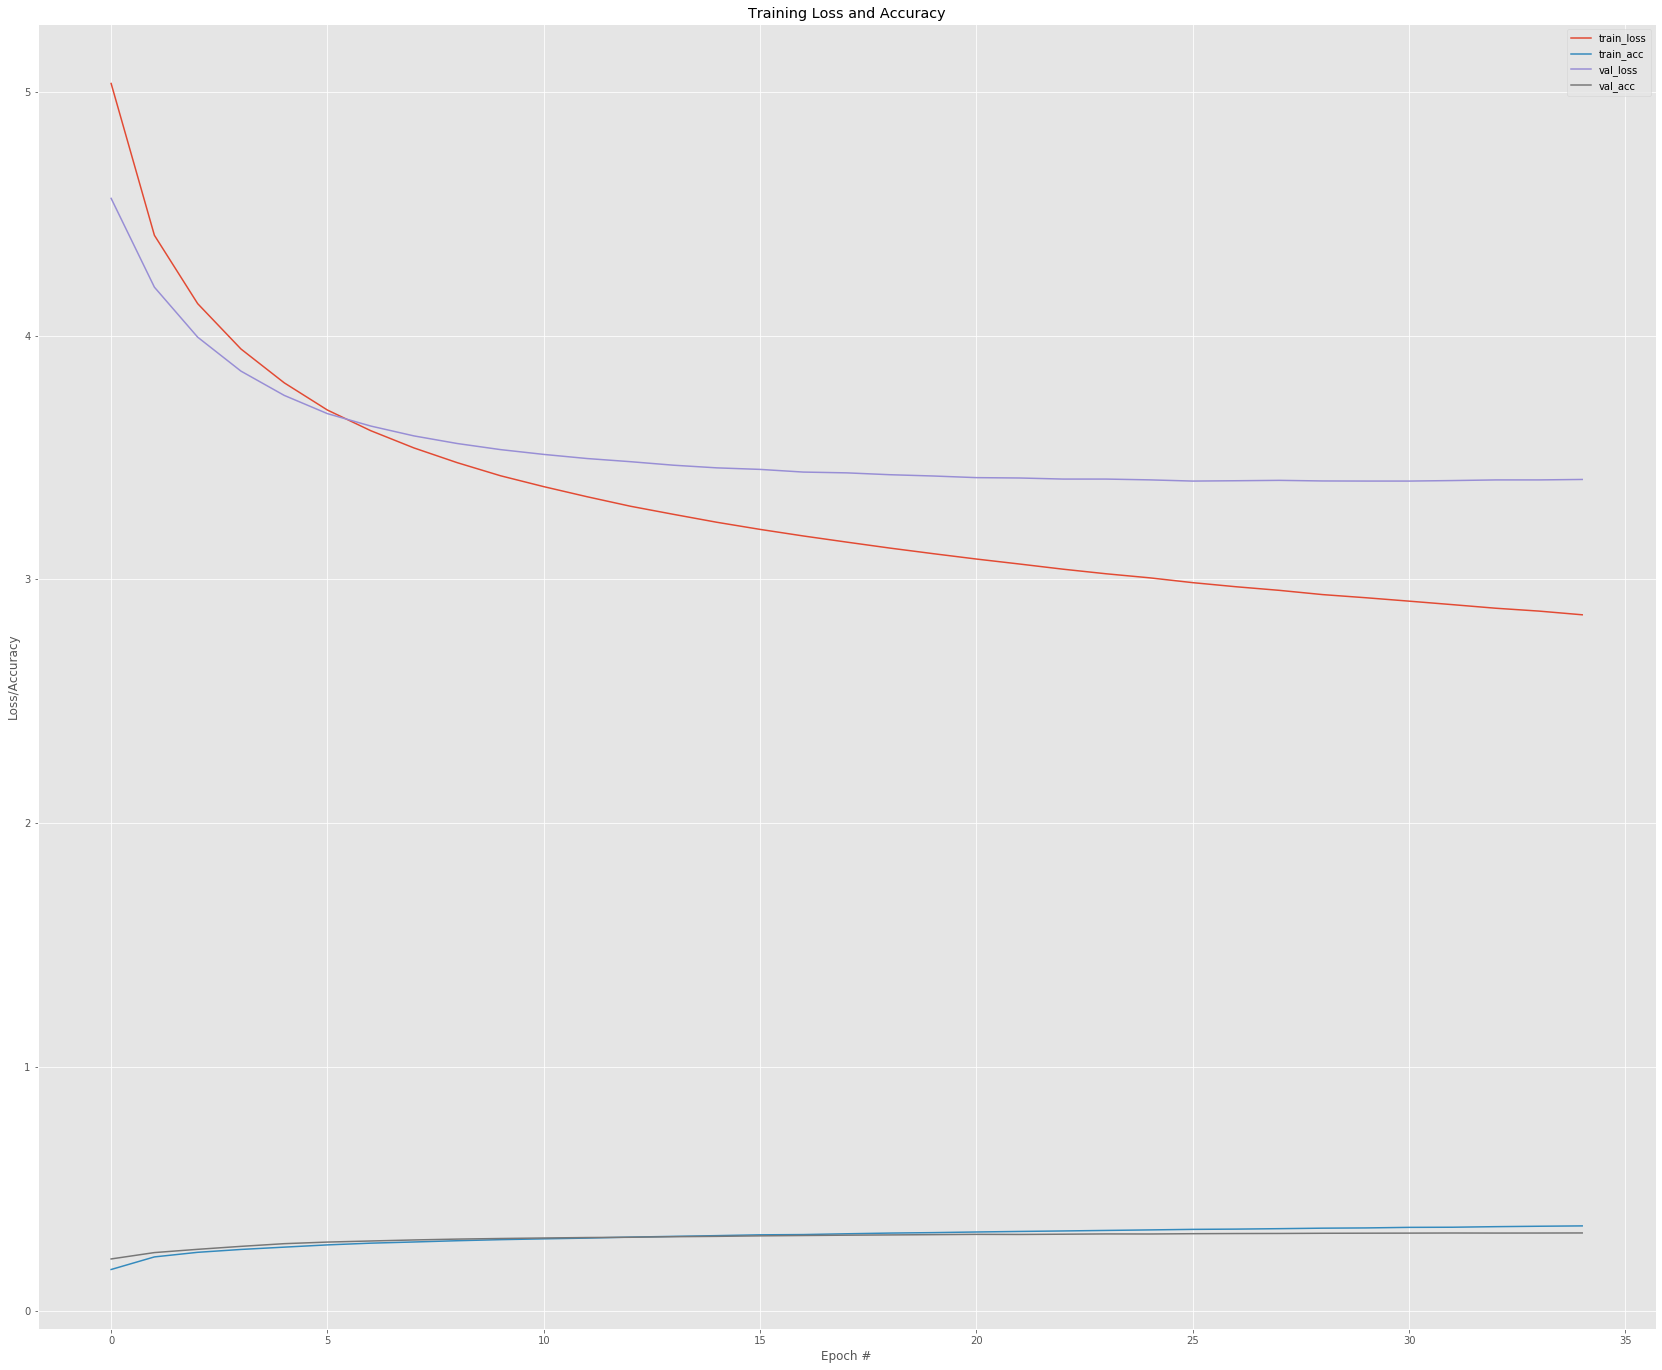

In [36]:
plt.style.use("ggplot")
plt.figure()
N = epochs
fig= plt.figure(figsize=(29,24))

plt.plot(np.arange(0, N), H2.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H2.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H2.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H2.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("model2.30.png")

<Figure size 432x288 with 0 Axes>

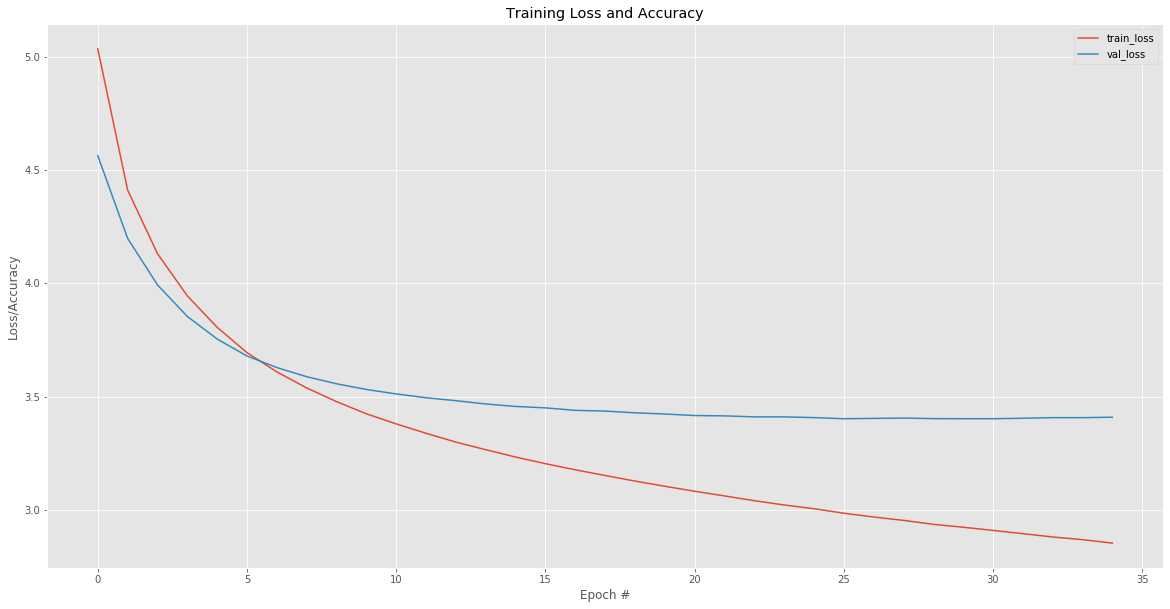

In [37]:
plt.style.use("ggplot")
plt.figure()
N = epochs
fig= plt.figure(figsize=(20,10))

plt.plot(np.arange(0, N), H2.history["loss"], label="train_loss")
#plt.plot(np.arange(0, N), H2.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H2.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, N), H2.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

<Figure size 432x288 with 0 Axes>

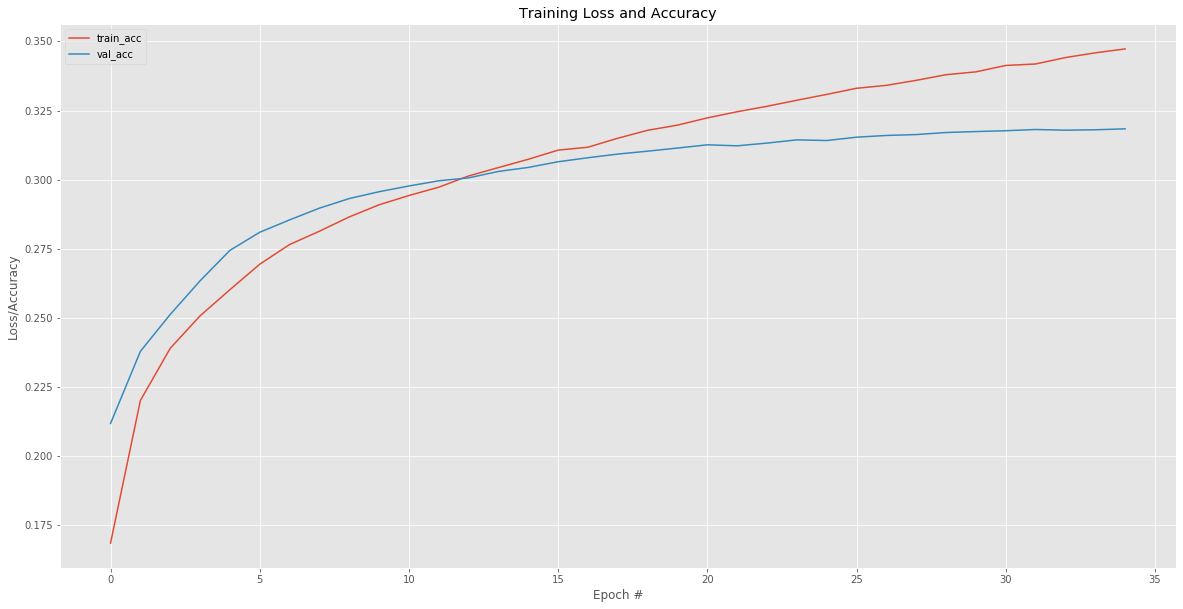

In [38]:
plt.style.use("ggplot")
plt.figure()
N = epochs
fig= plt.figure(figsize=(20,10))

#plt.plot(np.arange(0, N), H2.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H2.history["acc"], label="train_acc")
#plt.plot(np.arange(0, N), H2.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H2.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [39]:
model=load_model('VGG16_models/ck-loss2.986-val_loss3.403.h5')

In [43]:
images = 'Flickr8k_Dataset/'

In [44]:
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [45]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

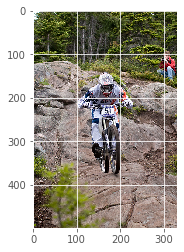

Greedy: man in red shirt and jeans is sitting on rocky path


In [62]:
pic = list(encoding_test.keys())[13]
image = encoding_test[pic].reshape((1,4096))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))